In [1]:
using Plots
using LaTeXStrings
using Distributions
using YFinance
using DataFrames

# Lucas Schmidt Ferreira de Araujo

## Geometric Brownian Motion

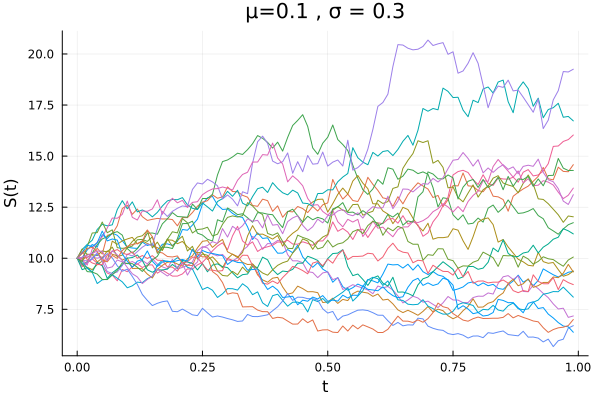

In [2]:
function GBM(nt , S0 , μ , σ , dt , nsim)
    S = zeros(nt,nsim)
    S[1 ,: ] .= S0
    dW = zeros(nsim)
    dS = zeros(nsim)
    t = [q*dt for q in 0:nt-1]
    for q in 1:nt-1
        dW .= sqrt(dt) .* randn(nsim)
        dS .= μ.*S[q,:].*dt + σ.* S[q,:] .* dW
        S[q+1,:] = S[q,:] .+ dS
    end
    return S , t
end

S , t = GBM(100 , 10 , .1 , .3 , .01 , 20)
plot(t , S , label = false , xlabel = "t" , ylabel = "S(t)" , title = "μ=0.1 , σ = 0.3")

## Black-Scholes Equation

- $V = V(S, t)$  is the price of the option as a function of the underlying asset price $S(t)$,
- $\sigma $ is the volatility of the underlying asset,
- $r$ is the risk-free interest rate
- $S(t)$ is the current price of the underlying asset,
- $t$ is the time, where $T-t$ represents time to maturity
- $K$ is the strike price

$$     \frac{\partial C}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 C}{\partial S^2} + r S \frac{\partial C}{\partial S} - rC = 0, $$

$$ C(0, t) = 0, \quad \text{for } 0 \leq t \leq T $$
$$ C(S, t) \approx S - K e^{-r(T - t)}, \quad \text{for } 0 \leq t \leq T $$

With terminal condition for a Call-Option

$$ C(S, T) = \max(S - K, 0) $$

## Analytical Solution

The analytical solution for Black-Scholes equations for a European call option is

$$ C(S, t) = S \Phi(d_1) - K e^{-r (T - t)} \Phi(d_2) $$

where:

$$ d_1 = \frac{\ln\left(\frac{S}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)(T - t)}{\sigma \sqrt{T - t}} $$
$$ d_2 = d_1 - \sigma \sqrt{T - t} $$

## Numerical Solution:

Using Euler's Explicit discretization, we find:

$$ C_{m+1}^{n} = \frac{1}{2} C_{m}^{n-1} (\alpha n^2 - \beta n) + 
    C_{m}^{n} (1 - \alpha n^2 - \beta) + 
    \frac{1}{2} C_{m}^{n+1} (\alpha n^2 + \beta n) $$
where:

$$ \alpha = \sigma^2 \Delta t $$
$$ \beta = r \Delta t$$

In [3]:
function BSC_FD(k, nx, SF, TF, σ, r, K)
    """
    Model: Black-Scholes Model for Call Option
    Numerical Method: Finite Difference Method
    """
    
    # Step size calculations
    c = 1 / (σ^2 * (nx - 1) + 0.5 * r)
    dt = k * c
    nt = Int(TF / dt)
    dx = SF / nx

    # Initialize matrices and vectors
    C = zeros(nt, nx)
    S = dx * collect(0:nx-1)
    t = dt * collect(0:nt-1)

    # Initial Condition
    C[1, :] .= max.(S .- K, 0)

    # Boundary Condition
    C[:, end] .= S[end] - K

    alfa = σ^2 * dt
    beta = r * dt

    # Finite Difference Loop
    for m in 1:(nt - 1)
        for n in 2:(nx - 1)
            C[m + 1, n] = 0.5 * C[m, n - 1] * (alfa * n^2 - beta * n) + 
                          C[m, n] * (1 - alfa * n^2 - beta) + 
                          0.5 * C[m, n + 1] * (alfa * n^2 + beta * n)
        end
    end

    return C, S, t
end

function BlackScholes(S, T, K, r, σ)
    """
        Black-Scholes Solution for Call Option
    """
    # Calculate d1 and d2
    d1 = (log(S / K) + (r + 0.5 * σ^2) * T) / (σ * sqrt(T))
    d2 = (log(S / K) + (r - 0.5 * σ^2) * T) / (σ * sqrt(T))
    C = S * cdf(Normal(0, 1), d1) - K * exp(-r * T) * cdf(Normal(0, 1), d2)
    return C
end

function ∂V∂S(S, T, K, r, σ)
    d1 = (log(S / K) + (r + 0.5 * σ^2) * T) / (σ * sqrt(T))
    return cdf(Normal(0, 1), d1)
end

function ∂²V∂S²(S::Float64,T::Float64 ,K::Float64, r::Float64, σ::Float64)
    d1 = (log(S / K) + (r + 0.5 * σ^2) * T) / (σ * sqrt(T))
    return pdf(Normal(0, 1), d1) / (S * σ * sqrt(T))
end

∂²V∂S² (generic function with 1 method)

┌ Info: Saved animation to /tmp/jl_8JAFmf6BoV.gif
└ @ Plots /home/lucas/.julia/packages/Plots/kLeqV/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_8JAFmf6BoV.gif")
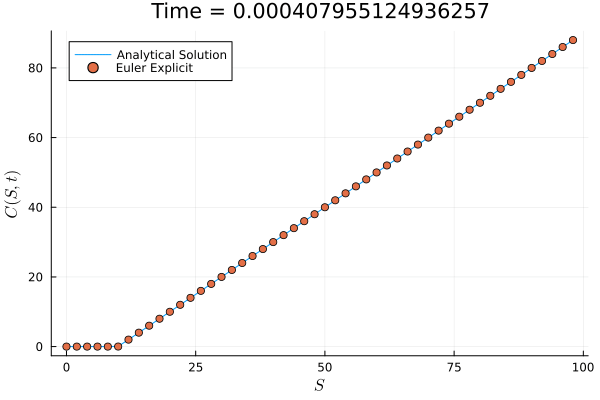

In [4]:
SF = 100    ### Final Stock Price
TF = 100    ### Final Time
K = 10      ### Strike Price

nx = 50     ### Number of space discrtizations
nsim = 1000 ### Number of Simulations
r = .05     ### Interest rate
μ = 1.2     ### Deterministic Part
σ = 1       ### Volatility

k = .02     ### Courrant Number

call_num , S , t = BSC_FD(k, nx, SF, TF, σ, r, K)
call_anl = [BlackScholes(j,q, K, r, σ) for q in t , j in S]

anim = @animate for q in 2:100:40002
    plot(S , call_anl[q,:] , label = "Analytical Solution")
    scatter!(S , call_num[q,:] , label = "Euler Explicit")
    ylabel!(L"C(S,t)")
    xlabel!(L"S")
    title!("Time = $(t[q])")
end

gif(anim)

## Delta-Hedging

1. Initial Cash Position
$$ m_0 = C(T) - \Delta(0)S(0)$$

2. Update Scheme
$$ m_i = e^{r\delta t}m_{i-1} - (\Delta(i) - \Delta(i-1))S(i)$$

3. Final Cash Position
$$ m_N = e^{r\delta t}m_{N-1} + \Delta(N-1)S(T) - max\{S-K,0\}$$

In [4]:
function Delta_Hedging_( S::Vector{Float64},
                        t::Vector{Float64},
                        K::Float64,
                        r::Float64,
                        σ::Float64,
                        itf::Int)

    dt = t[2] - t[1]
    nt = length(S)
    Δ = []                                                  ### Delta List
    tt = []                                                 ### Trading Time List

    C1 = max(S[end] - K,0)                                  ### Call Option
    v0 = BlackScholes(S[1] , t[end] - t[1] , K, r , σ)      ### Initial Call
    Δ0 = ∂V∂S(S[1], t[end] - t[1], K, r, σ)                 ### Initial Shares
    push!(Δ,Δ0)
    push!(tt , t[1])
    m  = v0 - Δ[1]*S[1]

    ### Main Loop
    for q in 2:itf:nt-1
        Δnew = ∂V∂S(S[q], t[end] - t[q], K, r, σ)       ### Calculate new delta
        m = m*exp(r * dt) - (Δnew - Δ[end]) * S[q]      ### Adjust the cash position
        push!(Δ,Δnew)                                   ### Store new delta value
        push!(tt , t[q])                                ### Store trading time
    end

    ### Final
    mT = exp(r*dt) * m + Δ[end] * S[end] - C1
    Δlast = ∂V∂S(S[end], t[end] - t[end], K, r, σ) 
    push!(Δ , Δlast)
    push!(tt , t[end])
    cost = exp(-r*t[end]) * mT / v0
    return cost , Δ , tt
end

function Delta_Hedging(  S::Vector{Float64},
                         t::Vector{Float64},
                         K::Float64,
                         r::Float64,
                         σ::Float64,
                         itf::Int)

    dt = t[2] - t[1]
    nt = length(S)

    C1 = max(S[end] - K,0)                                  ### Call Option
    v0 = BlackScholes(S[1] , t[end] - t[1] , K, r , σ)      ### Initial Call
    Δ = ∂V∂S(S[1], t[end] - t[1], K, r, σ)                 ### Initial Shares
    m  = v0 - Δ*S[1]

    ### Main Loop
    for q in 2:itf:nt-1
        Δnew = ∂V∂S(S[q], t[end] - t[q], K, r, σ)  ### Calculate new delta
        m = m*exp(r * dt) - (Δnew - Δ) * S[q]      ### Adjust the cash position
        Δ = Δnew
    end

    ### Final
    mT = exp(r*dt) * m + Δ * S[end] - C1
    cost = exp(-r*t[end]) * mT / v0
    return cost
end

Delta_Hedging (generic function with 1 method)

In [5]:
### Parameters

nt = 500        ### Number of Observations
dt = .001       ### Time interval
nsim = 10000    ### Number of Simulations

S0 = 100        ### Initial Stock price
μ = .01         ### Drift Term
σ = .2          ### Volatility
K = 110.0       ### Strike Price
r = .04         ### Interest rate

itf = 1         ### Frequency of intervals

S , t = GBM(nt , S0 , μ , σ , dt , nsim)

([100.0 100.0 … 100.0 100.0; 99.94072392849965 99.60975929347659 … 99.67721382875567 100.14509448755818; … ; 104.10508027825857 99.0797220666478 … 102.63899645610597 119.89027873318443; 104.14984428660337 98.9121578039412 … 102.83471588775207 119.42276504456075], [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001  …  0.49, 0.491, 0.492, 0.493, 0.494, 0.495, 0.496, 0.497, 0.498, 0.499])

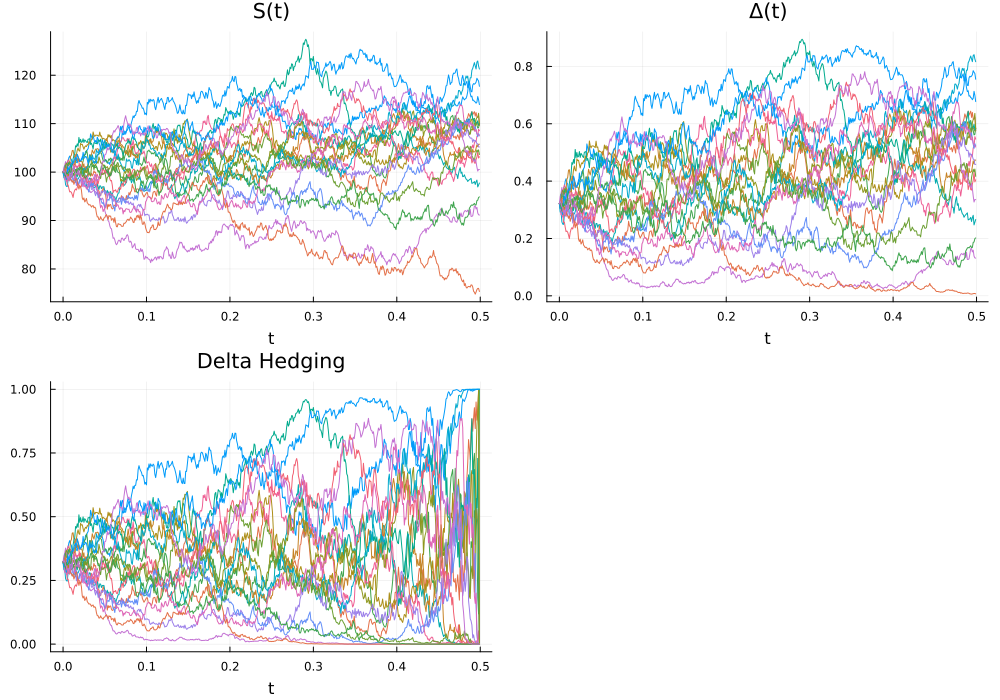

In [6]:
output = map( x -> Delta_Hedging_(collect(x) , t , K , r , σ , itf) , eachcol(S) )

costs = []
deltas = []
tts = []

for (cost, delta, tt) in output
    push!(costs, cost)
    push!(deltas, delta)
    tts = tt
end

p1 = plot(t,S[: , 1:20] , legend = false , title = "S(t)")
p2 = plot(t , ∂V∂S.(S[: , 1:20], t[end] - t[1], K, r, σ) , legend = false , title = "Δ(t)")
p3 = plot(tts , deltas[1:20] , legend = false , title = "Delta Hedging")

plot(p1 , p2 , p3 , size = (1000,700) , xlabel = "t" )

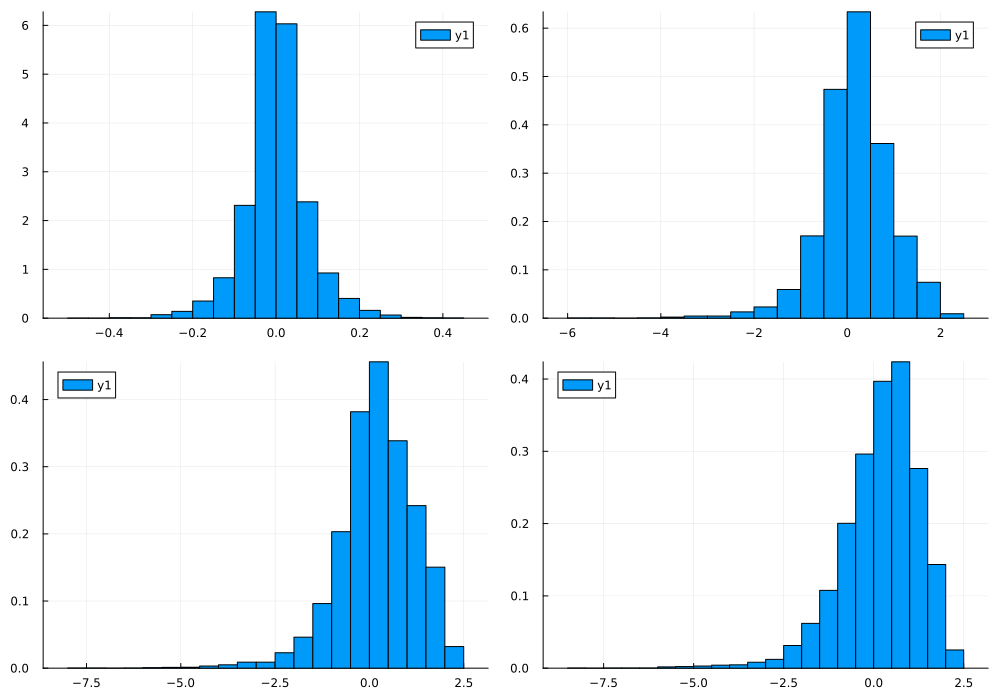

In [7]:
costs = [ map( x -> Delta_Hedging(collect(x) , t , K , r , σ , q) , eachcol(S) )  for q in 1:125:length(t)]
p1 = histogram(costs[1] , bins=20 , normalize = true)
p2 = histogram(costs[2] , bins=20 , normalize = true)
p3 = histogram(costs[3] , bins=20 , normalize = true)
p4 = histogram(costs[4] , bins=20 , normalize = true)

plot(p1,p2,p3,p4,size = (1000,700))

### Delta-Gamma Hedging

1. **Initial Cash Position**:
$$ m_0 = C(T) - \Delta(0)S(0) - \frac{1}{2} \Gamma(0) S(0)^2$$

2. **Updating the Cash Position at Each Time Step**:

$$ m_i = e^{r \delta t} m_{i-1} - (\Delta(i) - \Delta(i-1)) S(i) - \frac{1}{2} (\Gamma(i) - \Gamma(i-1)) S(i)^2 $$

3. **Final Cash Position**:
$$ m_N = e^{r \delta t} m_{N-1} + \Delta(N-1) S(T) - \max\{S(T) - K, 0\} - \frac{1}{2} \Gamma(N-1) S(T)^2 $$

In [140]:
function Delta_Gamma_Hedging(   S::Vector{Float64},
                                t::Vector{Float64},
                                K1::Float64,
                                K2::Float64,
                                r::Float64,
                                σ::Float64,
                                itf::Int)

    dt = t[2] - t[1]
    C = max(S[end] - K, 0)  
    v1 = BlackScholes(S[1], t[end] - t[1], K1, r, σ)  # Initial value of the target call option
    Δ1 = ∂V∂S(S[1], t[end] - t[1], K1, r, σ)          # Initial Delta
    Γ1 = ∂²V∂S²(S[1], t[end] - t[1], K1, r, σ)        # Initial Gamma

    # Use another option with different strike/volatility for gamma hedging
    v2 = BlackScholes(S[1], t[end] - t[1], K2, r, σ)
    Δ2 = ∂V∂S(S[1], t[end] - t[1], K2, r, σ)
    Γ2 = ∂²V∂S²(S[1], t[end] - t[1], K2, r, σ)

    # Calculate quantities to hedge both Delta and Gamma
    hedging_ratio = Γ1 / Γ2  # Amount of secondary options needed to neutralize Gamma
    ΔTotal = Δ1 - hedging_ratio * Δ2  # Combined Delta after Gamma adjustment
    m = v1 - ΔTotal * S[1] - hedging_ratio * v2  # Initial cash position

    ### Main Loop
    for q in 2:itf:length(t)-1
        Δ1new = ∂V∂S(S[q], t[end] - t[q], K1, r, σ)
        Γ1new = ∂²V∂S²(S[q], t[end] - t[q], K1, r, σ)

        v2new = BlackScholes(S[q], t[end] - t[q], K2, r, σ)
        Δ2new = ∂V∂S(S[q], t[end] - t[q], K2, r, σ)
        Γ2new = ∂²V∂S²(S[q], t[end] - t[q], K2, r, σ)

        ### Recalculate hedging ratios
        hedging_ratio_new = Γ1new / Γ2new
        ΔTotal_new = Δ1new - hedging_ratio_new * Δ2new

        ### Adjust the cash position
        m = m * exp(r * dt) - (ΔTotal_new - ΔTotal) * S[q] - (hedging_ratio_new - hedging_ratio) * v2new
        ΔTotal = ΔTotal_new
        hedging_ratio = hedging_ratio_new
    end

    ### Final calculation at maturity
    mT = exp(r * dt) * m + ΔTotal * S[end] + hedging_ratio * max(S[end] - K2, 0) - C
    cost = exp(-r * t[end]) * mT / v1
    return cost
end

Delta_Gamma_Hedging (generic function with 2 methods)

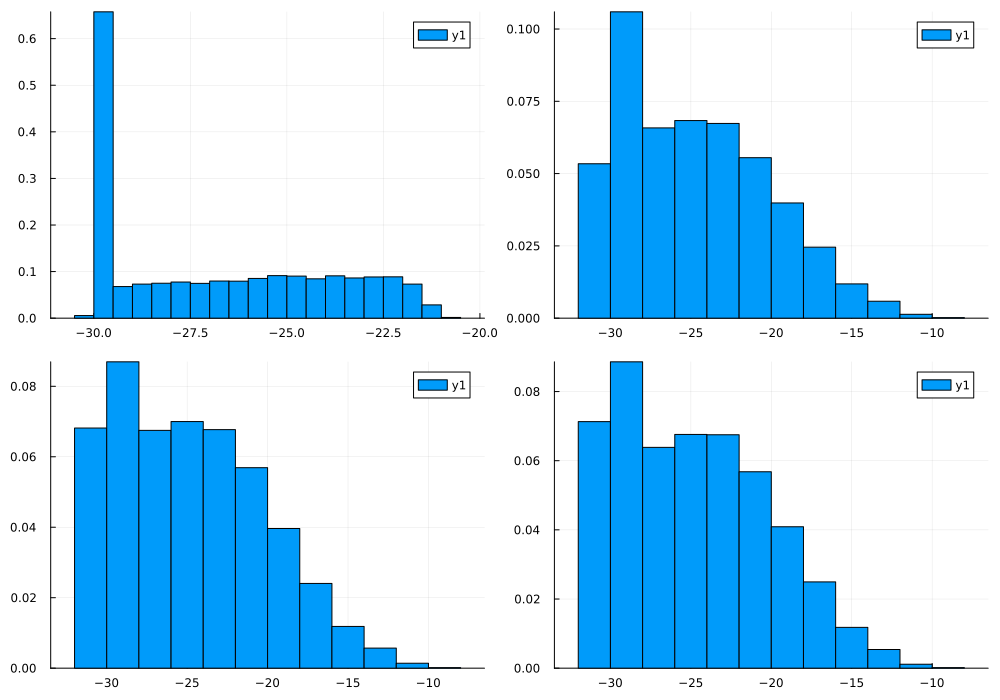

In [141]:

K1 = 110.0
K2 = 115.0
S , t = GBM(nt , S0 , μ , σ , dt , nsim)

costs = [ map( x -> Delta_Gamma_Hedging(collect(x) , t , K1, K2 , r , σ , q) , eachcol(S) )  for q in 1:125:length(t)]
p1 = histogram(costs[1] , bins=20 , normalize = true)
p2 = histogram(costs[2] , bins=20 , normalize = true)
p3 = histogram(costs[3] , bins=20 , normalize = true)
p4 = histogram(costs[4] , bins=20 , normalize = true)

plot(p1,p2,p3,p4,size = (1000,700))

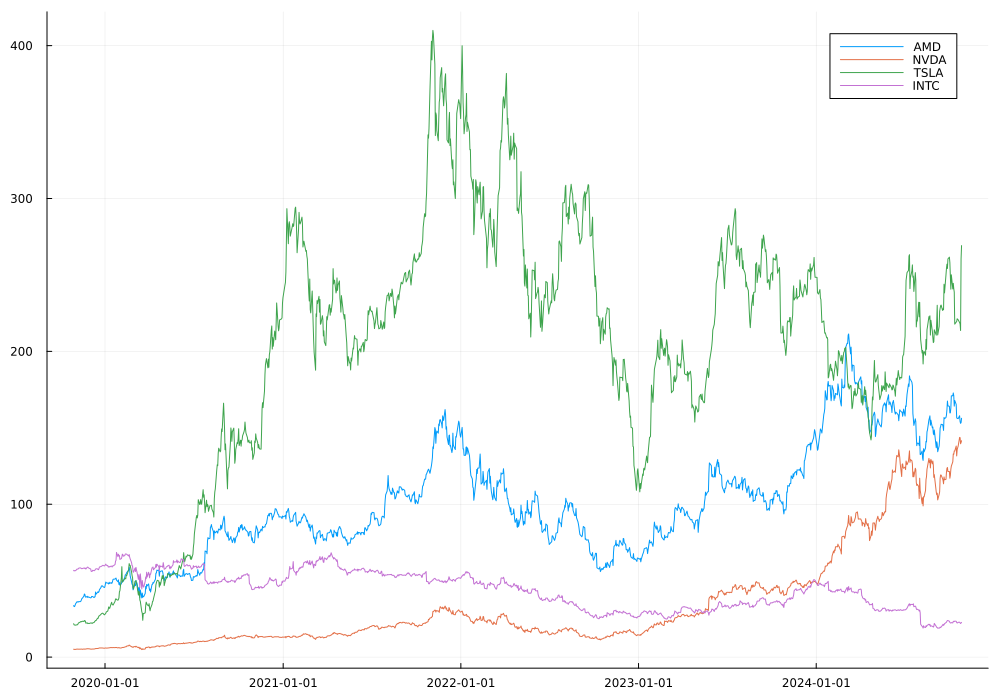

In [77]:
stocks = ["AMD" , "NVDA" , "TSLA" , "INTC"]
ms_in_a_year = 1000 * 60 * 60 * 24 * 365.25

df1 = DataFrame( get_prices(stocks[1],range="5y",interval="1d",divsplits=true,exchange_local_time=false) )
df2 = DataFrame( get_prices(stocks[2],range="5y",interval="1d",divsplits=true,exchange_local_time=false) )
df3 = DataFrame( get_prices(stocks[3],range="5y",interval="1d",divsplits=true,exchange_local_time=false) )
df4 = DataFrame( get_prices(stocks[4],range="5y",interval="1d",divsplits=true,exchange_local_time=false) )

plot( df1.timestamp , df1.close ,label = stocks[1] , size = (1000,700))
plot!( df2.timestamp , df2.close , label = stocks[2])
plot!( df3.timestamp , df3.close , label = stocks[3])
plot!( df4.timestamp , df4.close , label = stocks[4])

In [42]:
σ1_anualized_implied = sqrt( var( log.(df1.close[2:end]) .- log.(df1.close[1:end-1]) ) ) * sqrt(252)
σ2_anualized_implied = sqrt( var( log.(df2.close[2:end]) .- log.(df2.close[1:end-1]) ) ) * sqrt(252)
σ3_anualized_implied = sqrt( var( log.(df3.close[2:end]) .- log.(df3.close[1:end-1]) ) ) * sqrt(252)
σ4_anualized_implied = sqrt( var( log.(df4.close[2:end]) .- log.(df4.close[1:end-1]) ) ) * sqrt(252)

println("Annualized Volativity")
println("$(stocks[1]) : $(σ1_anualized_implied)")
println("$(stocks[2]) : $(σ1_anualized_implied)")
println("$(stocks[3]) : $(σ1_anualized_implied)")
println("$(stocks[4]) : $(σ1_anualized_implied)")

Annualized Volativity
AMD : 0.5219663197704225
NVDA : 0.5219663197704225
TSLA : 0.5219663197704225
INTC : 0.5219663197704225


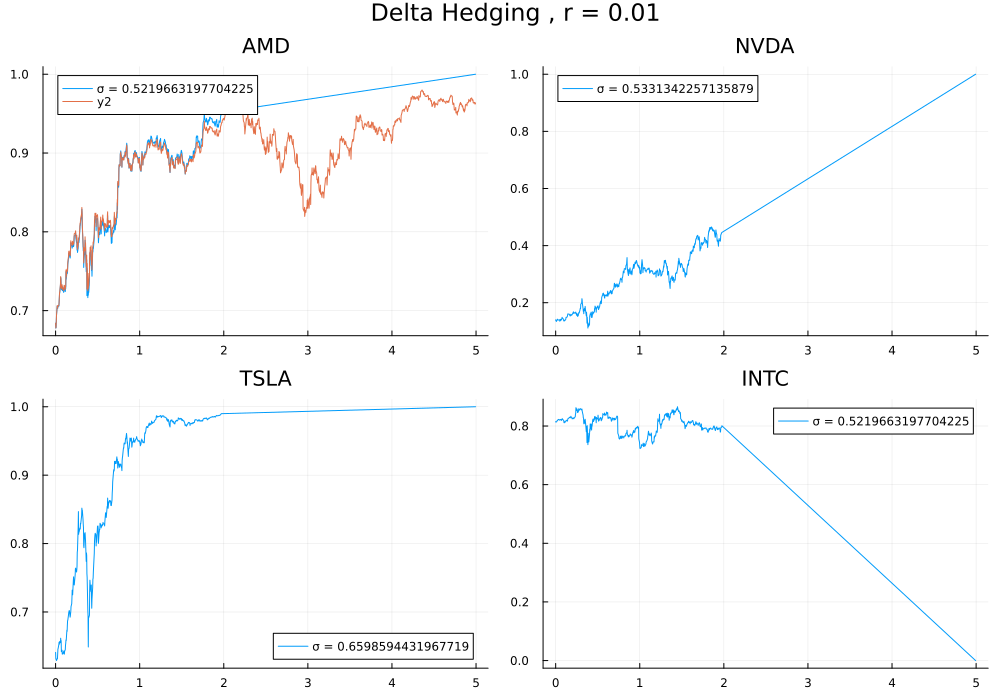

In [136]:
t = Dates.value.(df1.timestamp .- df1.timestamp[1]) ./ ms_in_a_year
S1 = df1.close
S2 = df2.close
S3 = df3.close
S4 = df4.close

K = 40.0
r = .01 

cost1 , Δ1 , tt1 =  Delta_Hedging_(S1 , t , K , r , σ1_anualized_implied , itf)
cost2 , Δ2 , tt2 =  Delta_Hedging_(S2 , t , K , r , σ2_anualized_implied , itf)
cost3 , Δ3 , tt3 =  Delta_Hedging_(S3 , t , K , r , σ3_anualized_implied , itf)
cost4 , Δ4 , tt4 =  Delta_Hedging_(S4 , t , K , r , σ4_anualized_implied , itf)

p1 = plot(tt1 , Δ1 , label = "σ = $(σ1_anualized_implied)" , title = stocks[1])
plot!( t, ∂V∂S.(S1, t[end], K, r, σ1_anualized_implied) )

p2 = plot(tt1 , Δ2 , label = "σ = $(σ2_anualized_implied)", title = stocks[2])
p3 = plot(tt1 , Δ3 , label = "σ = $(σ3_anualized_implied)", title = stocks[3])
p4 = plot(tt1 , Δ4 , label = "σ = $(σ1_anualized_implied)", title = stocks[4])

plot(p1,p2,p3,p4,size = (1000,700) ,suptitle = "Delta Hedging , r = $(r)")